# 1. Подготовка

Импортируем необходимые библиотеки.

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rnd_state = 702

Прочитаем файл с данными и посмотрим на него. При прочтении сразу переведем столбец `datetime` в формат `DateTime` и сделаем его индексным.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Информация по количеству заказов предоставлена за период с **1 марта 2018** по **31 августа 2018**. При этом количество заказов известно для каждых 10 минут.

Сделаем ресемплирование по одному часу, при этом количество заказов просуммируем.

In [3]:
data = data.resample('1H').sum()
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

Проверим, что данные временного ряда расположены в хронологическом порядке. Посмотрим на атрибут индекса `is_monotonic`.

In [5]:
data.index.is_monotonic

True

Проанализируем разные составляющие временного ряда. Для этого с помощью модуля `tsa.seasonal` разделим временной ряд на трендовую, сезонную и остаточную составляющие.

In [4]:
decomposed = seasonal_decompose(data)
trend = decomposed.trend
seasonal = decomposed.seasonal
resid = decomposed.resid

Для начала рассмотрим трендовую составляющую.

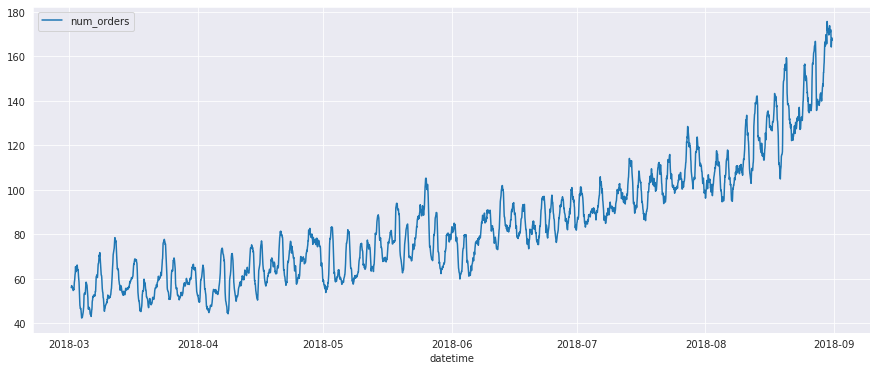

In [6]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=trend)
plt.show()

Количество заказов растет на протяжении всего временного ряда. Теперь рассмотрим сезонную составляющую.

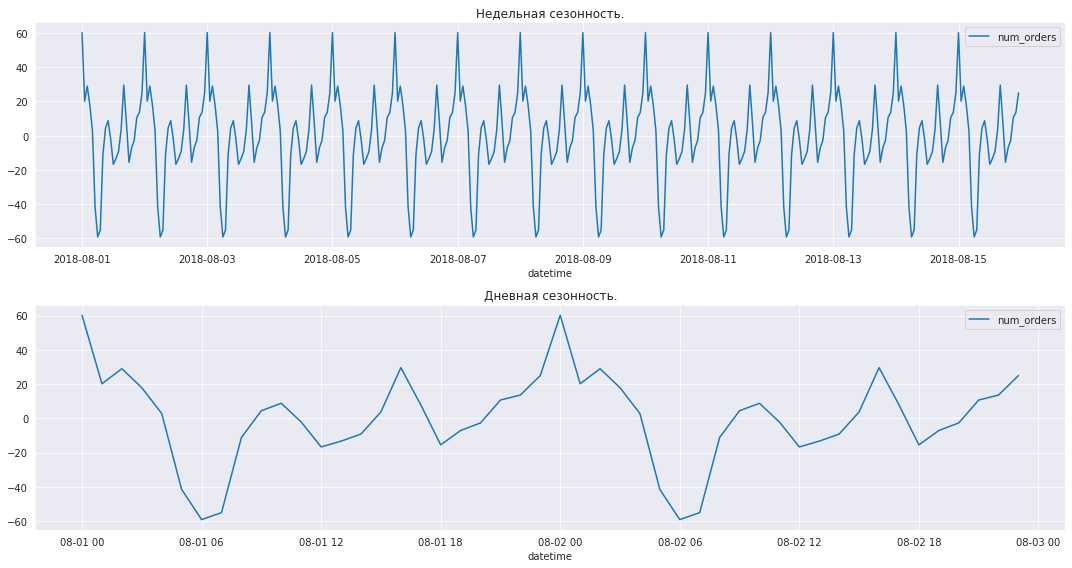

In [7]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
sns.lineplot(data=seasonal['2018-08-01':'2018-08-15'])
plt.title('Недельная сезонность.')
plt.subplot(212)
sns.lineplot(data=seasonal['2018-08-01':'2018-08-02'])
plt.title('Дневная сезонность.')
plt.tight_layout()
plt.show()

Как мы видим, количество заказов не меняется в зависимости от дня недели, число заказов в будний день такое же, как и в выходной. Но при этом часовая (суточная) сезонность присутствует: пик приходится на полночь, затем резкое падение до минимума к 6 часам утра, а далее в течение дня идут средние значения.

Проверим, меняется ли сезонность в течение всего временного ряда.

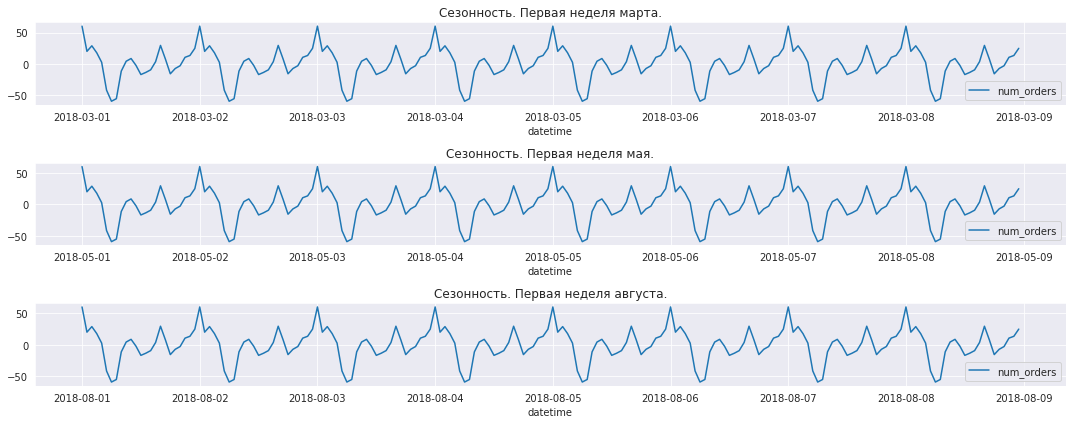

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(311)
sns.lineplot(data=seasonal['2018-03-01':'2018-03-08'])
plt.title('Сезонность. Первая неделя марта.')
plt.subplot(312)
sns.lineplot(data=seasonal['2018-05-01':'2018-05-08'])
plt.title('Сезонность. Первая неделя мая.')
plt.subplot(313)
sns.lineplot(data=seasonal['2018-08-01':'2018-08-08'])
plt.title('Сезонность. Первая неделя августа.')
plt.tight_layout()
plt.show()

Сезонная постоянная одинакова для начала, середины и конца временного ряда.

Для будущего обучения моделей создадим дополнительные признаки из имеющейся выборки. Создадим функцию, которая будет добавлять календарные признаки, отстающие значения и скользящее среднее.

Применим эту функцию к нашей выборке и удалим пропуски, получающиеся в первых строках.

Из календарных признаков оставим только часы и дни недели, так как они образуют сезонность в нашем временном ряду.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    for i in range(max_lag):
        col_name = 'lag_' + str(i+1)
        data[col_name] = data['num_orders'].shift(i+1)
        
make_features(data, 5, 24)
data = data.dropna()
display(data)

,num_orders,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,
2018-03-02 00:00:00,90,4,0,56.833333,58.0,113.0,66.0,61.0,45.0
2018-03-02 01:00:00,120,4,1,55.416667,90.0,58.0,113.0,66.0,61.0
2018-03-02 02:00:00,75,4,2,56.875000,120.0,90.0,58.0,113.0,66.0
2018-03-02 03:00:00,64,4,3,57.041667,75.0,120.0,90.0,58.0,113.0
2018-03-02 04:00:00,20,4,4,56.958333,64.0,75.0,120.0,90.0,58.0
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,164.875000,207.0,217.0,197.0,116.0,133.0
2018-08-31 20:00:00,154,4,20,167.541667,136.0,207.0,217.0,197.0,116.0
2018-08-31 21:00:00,159,4,21,168.041667,154.0,136.0,207.0,217.0,197.0


Признаки готовы, можно переходить к обучению моделей.

# 3. Обучение

Первым делом разобьем имеющуюся выборку на обучающую и тестовую в отношении 9:1, а также выделим целевой признак.

Так как мы работаем с временными рядами, то параметр перемешивания установим `shuffle=False`.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='num_orders'), data['num_orders'], test_size=0.1, shuffle=False)

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(3952, 8)
(440, 8)
(3952,)
(440,)


Так как при кросс-валидации временных рядов создаваемая тестовая подвыборка должна хронологически идти за обучающей, то стандартное случайное разбиение не подходит. С помощью `TimeSeriesSplit` создадим обучающие и тестовые подвыборки для кросс-валидации, расположенные в хронологическом порядке.

![TimeSeriesSplit](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png)

In [11]:
tscv = TimeSeriesSplit(n_splits=3)
cv = []
for train, test in tscv.split(X_train):
    cv.append((train, test))

Создадим вспомогательные функции для вывода метрик `RMSE` и `R2` для этапов кросс-валидации и тестирования моделей. Эти функции пригодятся нам позже.

Также создадим метрику `neg_root_mean_squared_error` для использования в функциях `cross_val_score` и `GridSearchCV`.

In [14]:
def neg_rmse(y_true, y_pred):    
    return mean_squared_error(y_true, y_pred) ** 0.5

neg_root_mean_squared_error = make_scorer(neg_rmse, greater_is_better=False)

def ts_cv_score_printout(model, X, y):
    """
    Функция выводит на экран усредненное значение метрик RMSE и R2
    при кросс-валидации для временных рдяов.
    На входе:
    model - используемая модель
    X - признаки для обучения модели
    y - целевой признак
    """
    X = np.array(X)
    y = np.array(y)
    rmse_array = []
    r2_array = []
    tscv = TimeSeriesSplit(n_splits=3)
    for train, test in tscv.split(X):
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        rmse = mean_squared_error(y[test], y_pred) ** 0.5
        rmse_array.append(rmse)
        r2 = r2_score(y[test], y_pred)
        r2_array.append(r2)
    print('-' * 50) 
    print('Time Series Cross validation RMSE score: {:.2f}'.format(np.mean(np.array(rmse_array))))
    print('Time Series Cross validation R2 score: {:.3f}'.format(np.mean(np.array(r2_array))))
    print('-' * 50) 
    
def test_score_printout(y_pred, y_test):
    """
    Функция выводит на экран значение метрик RMSE и R2.
    На входе:
    y_pred - предсказания модели
    y_test - целевой признак 
    """
    print('-' * 50)      
    print('Test RMSE score: {:.2f}'.format(mean_squared_error(y_test, y_pred) ** 0.5))
    print('Test R2 score: {:.3f}'.format(r2_score(y_test, y_pred)))
    print('-' * 50)

## 3.1. Линейная регрессия

Начнем с модели линейной регрессии.

In [16]:
%%time

model_lr = LinearRegression()

model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

ts_cv_score_printout(model_lr, X_train, y_train)

--------------------------------------------------
Time Series Cross validation RMSE score: 32.74
Time Series Cross validation R2 score: 0.177
--------------------------------------------------
CPU times: user 17.5 ms, sys: 4.23 ms, total: 21.7 ms
Wall time: 11.9 ms


Показатель RMSE на обучающей выборке 32.74. Переходим к дереву решений.

## 3.2. Дерево решений

Переберем пару гиперпараметров - `criterion` и `max_depth`.

In [25]:
%%time

parameters = {
    'criterion' : ['mse', 'friedman_mse'],
    'max_depth' : [2, 5, 8, 11],
}

grid = GridSearchCV(DecisionTreeRegressor(random_state=rnd_state), parameters, scoring=neg_root_mean_squared_error, cv=cv)
grid.fit(X_train, y_train)
print('Best parameters :', grid.best_params_)
print('Best score :', grid.best_score_)
print()

Best parameters : {'criterion': 'mse', 'max_depth': 5}
Best score : -32.981019389620805

CPU times: user 282 ms, sys: 0 ns, total: 282 ms
Wall time: 283 ms


Метрика RMSE примерно такая же, как и на линейной регрессии. Посмотрим, сможет ли лес улучшить её.

## 3.3. Случайный лес

Переберем такие гиперпараметры, как количество деревьев и максимальная глубина.

In [26]:
%%time

parameters = {
    'n_estimators' : [5, 20, 35, 100],
    'max_depth' : [2, 5, 10]
}

grid = GridSearchCV(RandomForestRegressor(random_state=rnd_state), parameters, scoring=neg_root_mean_squared_error, cv=cv)
grid.fit(X_train, y_train)
print('Best parameters :', grid.best_params_)
print('Best score :', grid.best_score_)
print()

Best parameters : {'max_depth': 10, 'n_estimators': 100}
Best score : -28.177250374737152

CPU times: user 8.68 s, sys: 0 ns, total: 8.68 s
Wall time: 8.89 s


Случайный лес добился лучшего результата, чем предыдущие модели. Теперь взглянем на модели градиентного бустинга, проверим модели от `LightGBM` и `CatBoost`.

## 3.4. Градиентный бустинг - LightGBM

По сетке переберем такие параметры как `learning_rate` и `n_estimators`.

In [27]:
%%time

parameters = {
    'learning_rate' : [0.1, 0.3, 0.5],
    'n_estimators' : [50, 100, 150]
}

grid = GridSearchCV(LGBMRegressor(random_state=rnd_state), parameters,
                    scoring=neg_root_mean_squared_error, cv=cv)
grid.fit(X_train, y_train)
print('Best parameters :', grid.best_params_)
print('Best score :', grid.best_score_)
print()

Best parameters : {'learning_rate': 0.1, 'n_estimators': 50}
Best score : -27.64918190290379

CPU times: user 12min 38s, sys: 5.25 s, total: 12min 44s
Wall time: 12min 49s


Метрика RMSE еще лучше, чем у случайного леса. Сравним её с результатом модели от `CatBoost`.

## 3.5. Градиентный бустинг - CatBoost

По сетке переберем такие параметры как `learning_rate` и `iterations`.

In [28]:
%%time

parameters = {
    'iterations' : [50, 125, 200, 400],
    'learning_rate' : [0.1, 0.5],
}

grid = GridSearchCV(CatBoostRegressor(random_state=rnd_state, silent=True),
                    parameters, scoring=neg_root_mean_squared_error, cv=cv)
grid.fit(X_train, y_train)
print('Best parameters :', grid.best_params_)
print('Best score :', grid.best_score_)
print()

Best parameters : {'iterations': 200, 'learning_rate': 0.1}
Best score : -27.60070232282489

CPU times: user 54 s, sys: 6.41 s, total: 1min
Wall time: 1min 35s


Модель от `CatBoost` слегка обошла модель градиентного бустинга от `LightGBM`, остановимся на этой модели.

# 4. Тестирование

Проверим, какое значение метрики RMSE получится у модели от `CatBoost` на тестовой выборке. Применим гиперпараметры, которые показали лучший результат на обучающей выборке.

In [29]:
%%time

model_cbr = CatBoostRegressor(iterations=200, learning_rate=0.1, verbose=40)

model_cbr.fit(X_train, y_train)
y_pred = model_cbr.predict(X_test)

test_score_printout(y_pred, y_test)

0:	learn: 36.8928343	total: 2.85ms	remaining: 567ms
40:	learn: 23.0463704	total: 644ms	remaining: 2.5s
80:	learn: 21.1596580	total: 1.32s	remaining: 1.94s
120:	learn: 19.9658449	total: 2.02s	remaining: 1.32s
160:	learn: 18.8286185	total: 2.9s	remaining: 702ms
199:	learn: 18.1002225	total: 3.98s	remaining: 0us
--------------------------------------------------
Test RMSE score: 44.49
Test R2 score: 0.424
--------------------------------------------------
CPU times: user 3.76 s, sys: 443 ms, total: 4.21 s
Wall time: 5.3 s


Показатель RMSE на тестовой выборке заметно хуже, чем на обучающей, модель переобучилась.

Визуально оценим, где больше всего модель ошибается. Построим график предсказаний модели и действительных значений.

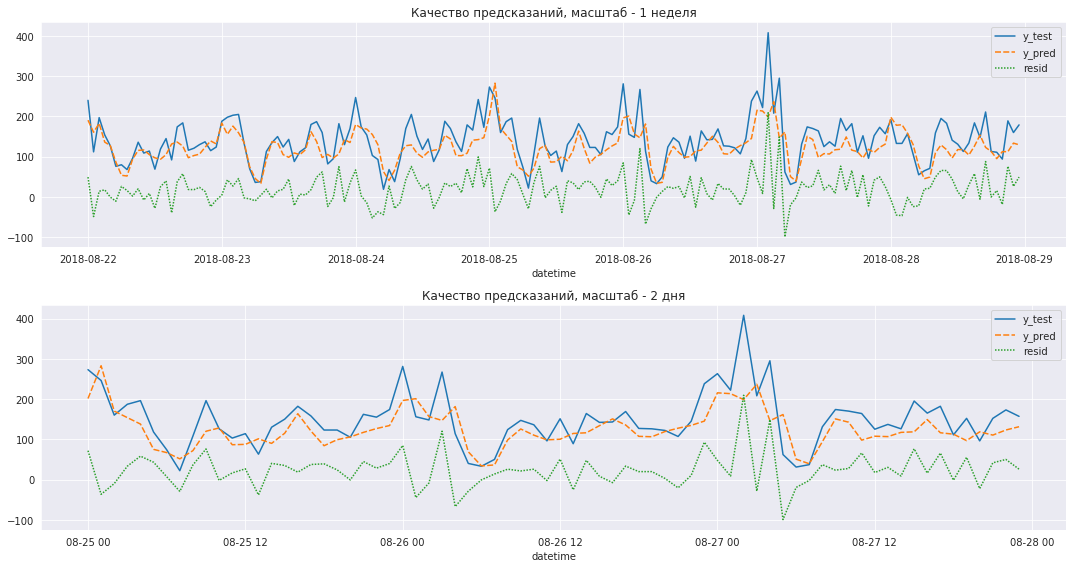

In [30]:
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index
result = pd.concat([y_test, y_pred], axis=1)
result.columns = ['y_test', 'y_pred']
result['resid'] = result['y_test'] - result['y_pred']

plt.figure(figsize=(15, 8))
plt.subplot(211)
sns.lineplot(data=result['2018-08-22':'2018-08-28'])
plt.title('Качество предсказаний, масштаб - 1 неделя')
plt.subplot(212)
sns.lineplot(data=result['2018-08-25':'2018-08-27'])
plt.title('Качество предсказаний, масштаб - 2 дня')
plt.tight_layout()
plt.show()

Как мы видим, модель плохо предсказывает резкие колебания значений, график предсказаний более ровный. Скорее всего у модели плохо получается предсказывать случайные колебания величины, но это нормально.

Итоговый показатель RMSE на тестовой выборке меньше 48, требуемых по заданию. Считаем, что модель справилась с задачей. 

Напоследок выполним быструю проверку модели на адекватность. Сравним показтель RMSE модели с этим же показателем у константной модели, которая предсказывает среднее значение по обучающей выборке.

In [31]:
dummy_pred = np.ones(y_test.shape) * data['num_orders'].mean()

print('Test RMSE score: {:.2f}'.format(mean_squared_error(y_test, dummy_pred) ** 0.5))

Test RMSE score: 80.38


RMSE предсказаний модели заметно ниже, чем у константной модели, проверка на адекватность пройдена.

# 5. Выводы

Мы построили несколько моделей для предсказания количества заказов и проверили их с помощью кросс-валидации временных рядов. Худший результат у линейной регрессии и дерева решений; случайный лес проявил себя лучше, но модели градиентного бустинга оказались равно впереди. Лучшая модель на обучающей выборке - модель от `CatBoost`, результат на тестовой выборке: `RMSE = 44.49`, цель проекта выполнена.